# Cryptocurrency Prophet

In [1]:
!pip install pandas prophet requests ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.1 MB/s eta 0:00:00


In [12]:
#@title Using Python Prophet and CoinCap for crpytocurrency predictions.
#@markdown Created a list of all the available currencies via CoinCap.<br>
#@markdown Used historical pricing on a 1 day basis as our dataset.

import logging
logging.basicConfig()
logger = logging.getLogger('foo')
logger.setLevel(logging.ERROR)

import sys
from datetime import datetime
from typing import List, Set

import pandas as pd
import requests
from prophet import Prophet


proxies = {
    # 'https': 'https://116.254.116.99:8080'
}

requests.Session().get('https://api.coincap.io/v2/assets', proxies=proxies)

def get_supported_currencies_datasets() -> List[str]:
    try:
      datasets = requests.Session().get('https://api.coincap.io/v2/assets', proxies=proxies).json()
    except Exception as e:
      print(e)
      print('Failed to get the list of currencies from coincap. Please retry.')
      return
    coins = [f['id'] for f in datasets['data']]
    return coins


def predict_currencies(currencies: Set[str]):
    currencies = [c for c in currencies if c]
    futures = []
    forecasts = []
    for currency_name in currencies:
        print("Forcasting", currency_name)
        # Get the dataset
        try:
          historical_data = requests.Session().get(f'https://api.coincap.io/v2/assets/{currency_name}/history?interval=d1', proxies=proxies).json()[
              'data']
        except Exception:
          print(f'Failed to get the data for {currency_name} from coincap. Please retry.')
          return

        df = pd.DataFrame.from_dict(historical_data)

        # Normalization
        print("Normalizing the data...")
        df.rename(columns={"time": "ds", "priceUsd": "y"}, inplace=True)
        # Stripping timezone
        df['ds'] = df['ds'].apply(lambda timestamp: datetime.fromtimestamp(int(timestamp) / 1000))
        df['ds'] = df['ds'].apply(lambda d: d.replace(tzinfo=None))
        df['ds'] = pd.to_datetime(df['ds'])
        df['ds'].dt.tz_localize(None)

        # Fit
        print("Creating a time-series model...")
        m = Prophet(seasonality_mode='multiplicative', daily_seasonality=True, yearly_seasonality=True).fit(df)

        # Predictions
        future = m.make_future_dataframe(periods=90, include_history=False)
        forecast = m.predict(future)
        futures.append(future)
        forecasts.append(forecast)
        print(f"Forecast for {currency_name}: ")
        print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
        forecast_plt = m.plot(forecast)
        forecast_gca = forecast_plt.gca()
        forecast_gca.set_title(f"{currency_name.upper()} Forecast", size=34)
        forecast_plt.show()
        # components_plt = m.plot_components(forecast)
        # components_gca = components_plt.gca()
        # components_gca.set_title(f"{currency_name.upper()} Components", size=34)
        # components_plt.show()

    return forecasts

In [18]:
#@title List all currencies fetched on CoinCap
#@markdown Select a crypto
supported_currencies = get_supported_currencies_datasets()
if supported_currencies:
  import ipywidgets as widgets
  selection = widgets.SelectMultiple(
      options=supported_currencies,
      value=['ethereum'],
      rows=100,
      description='Currencies',
      disabled=False
  )
  display(selection)

SelectMultiple(description='Currencies', index=(1,), options=('bitcoin', 'ethereum', 'tether', 'binance-coin',…

Predicting  ('bitcoin',)
Forcasting bitcoin


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqfbwtcst/gfcs6442.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqfbwtcst/60t3x2tf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22979', 'data', 'file=/tmp/tmpqfbwtcst/gfcs6442.json', 'init=/tmp/tmpqfbwtcst/60t3x2tf.json', 'output', 'file=/tmp/tmpqfbwtcst/prophet_modelkx5sozl9/prophet_model-20230621104200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:42:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Normalizing the data...
Creating a time-series model...
Forecast for bitcoin: 
           ds          yhat    yhat_lower    yhat_upper
85 2023-09-14  24062.801616  23075.816797  25068.972665
86 2023-09-15  24098.388693  23058.391984  25104.682543
87 2023-09-16  24199.972343  23095.620461  25286.650269
88 2023-09-17  24246.047978  23140.159436  25276.678231
89 2023-09-18  24200.258902  23178.690712  25237.040632


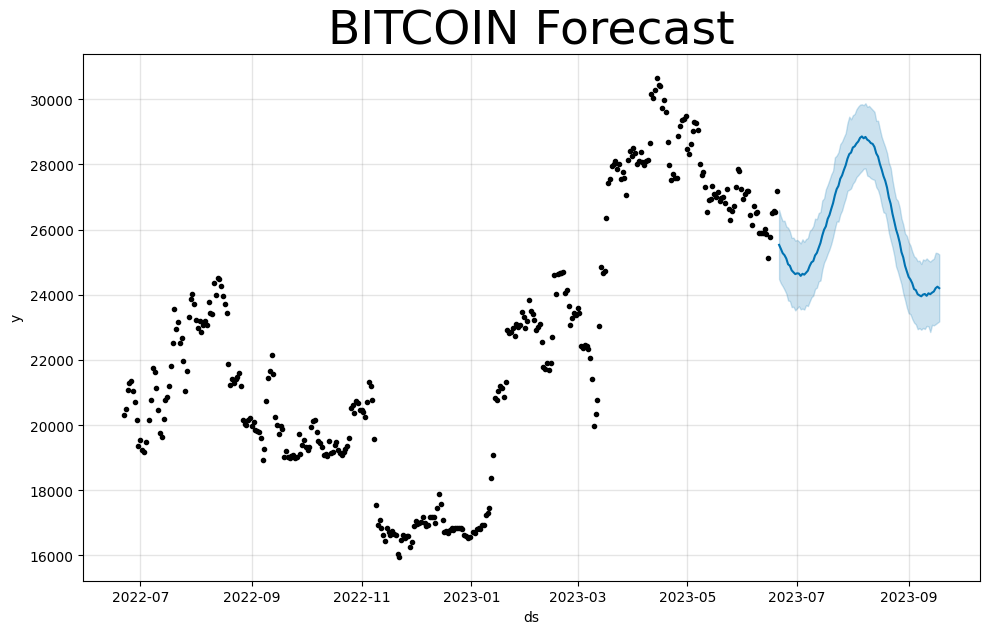

In [20]:
#@title Run the predictions on the selected currencies
currencies = selection.value
print('Predicting ',currencies)
forecasts = predict_currencies(selection.value)